This notebook contains the source code to reproduce the results of hierarchical Bayesian calibration for different MFU representations.

In [3]:
import numpy as np
from dispersion_MFU_representations import *
from Bayes import *
from TruthModel import *

#Matplotlib options to get Times face and LaTeX for the paper.
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
import matplotlib.pyplot as plt

prior_colors=('#bcd5e7','C0')
posterior_colors=('#c7a5d6', '#8119b5')

In [4]:
t_calibration=0.3
FRADE_truth_model = FRADETruthModel(nu_m=0.1, alpha=1.5)
generalizedADE_truth_model = generalizedADETruthModel(16)

# Model can represent the true signal

We don't learn much when the model can actually reproduce the data. 

In [34]:
m = onlyFRADEMFU(FRADE_truth_model, t_calibration=t_calibration, results_dir='results/contaminant_transport/example_1/')

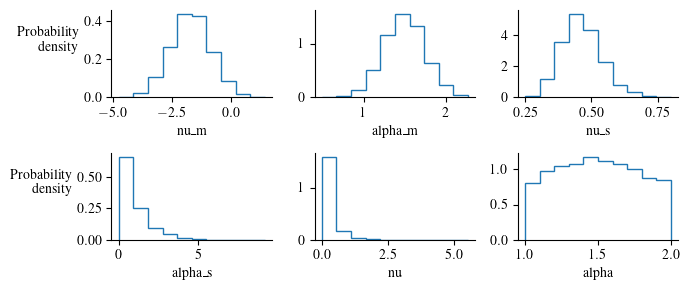

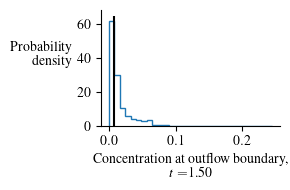

In [35]:
np.random.seed(20250810)
prior_samples = m.get_prior_samples(5000)
m.plot_marginal_histograms(prior_samples)
m.plot_qoi_pushforward(prior_samples,with_noise=True)

100%|██████████| 5000/5000 [01:06<00:00, 75.22it/s]


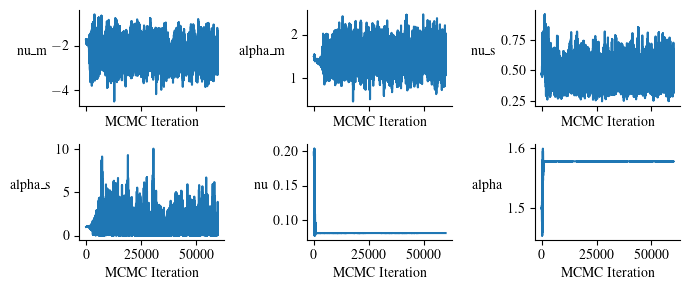

In [36]:
m.run_mcmc(5000)
m.plot_mcmc_chains()

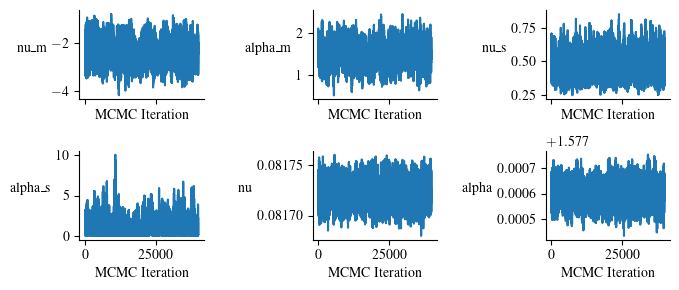

In [37]:
samples = m.chains[20000:]
m.plot_mcmc_chains(samples)

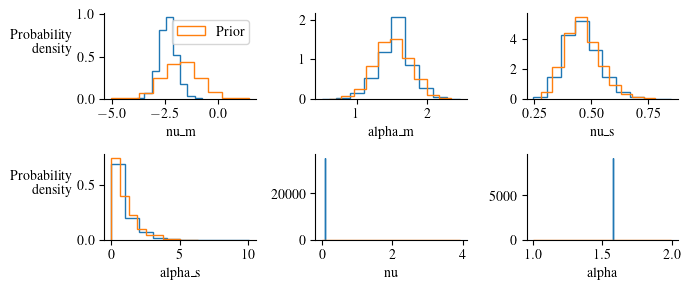

In [38]:
m.plot_marginal_histograms(samples, vs_prior=True)

Getting prior/posterior predictive samples and quantiles

In [39]:
pri_pred_samples = m.get_qoi_pushforward_samples(prior_samples)
# Hierarchically sample MFU parameters from hyperparameters
pps = m.get_posterior_pushforward_samples(samples[::10]) # downsampling
post_pred_samples = m.get_qoi_pushforward_samples(pps)

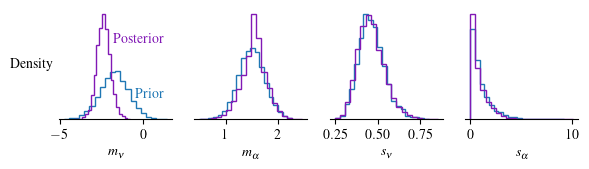

In [40]:
fig = plt.figure(figsize=(6,1.8))
axs = fig.subplots(1,4)
bins=20
labels = [ r'$m_\nu$', r'$m_\alpha$', r'$s_\nu$', r'$s_\alpha$' ]
for ax, pris, posts, label in zip(axs, prior_samples.T, samples[:,:-2].T, labels):
    ax.hist(pris, histtype='step', density=True, bins=bins, color=prior_colors[1]);
    ax.hist(posts, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
    ax.set_xlabel(label)

axs[0].set_ylabel('Density', rotation=0, ha='right', va='center')

for ax in axs:
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_yticks([])

axs[0].annotate('Prior', (-0.5,0.25), ha='left', va='center', color=prior_colors[1]);
axs[0].annotate('Posterior', (-1.8,0.8), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/marginals.pdf', bbox_inches='tight')

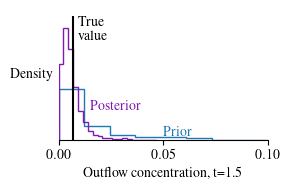

In [41]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
bins=20
ax.hist(pri_pred_samples, histtype='step', density=True, bins=bins, color=prior_colors[1]);
ax.hist(post_pred_samples, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
qtrue = m.truth_model.f_field_from_eigenvalues()[0]
ax.vlines(qtrue, 0, 1.05*ax.get_ylim()[1], color='k')
ax.annotate('True\nvalue', (qtrue*1.3, 0.95*ax.get_ylim()[1]), ha='left', va='top')


ax.set_ylabel('Density', rotation=0, ha='right', va='center')
ax.spines[['top','left','right']].set_visible(False)
ax.set_yticks([])

ax.set_xlim([0,0.1])
ax.set_xticks([0,0.05,0.1])

ax.set_xlabel(f'Outflow concentration, t={m.truth_model.t}');
ax.annotate('Prior', (.05,8), ha='left', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.015,35), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/qoi_predictives.pdf', bbox_inches='tight')

In [42]:
t_pred = 1
pri_pred_x_samples = m.get_spatial_pushforward_samples(prior_samples, t=t_pred)
post_pred_x_samples = m.get_spatial_pushforward_samples(pps, t=t_pred)
pri_x_q5, pri_x_q95 = np.quantile(pri_pred_x_samples, q=[.025,.975], axis=0)
post_x_q5, post_x_q95 = np.quantile(post_pred_x_samples, q=[.025,.975], axis=0)

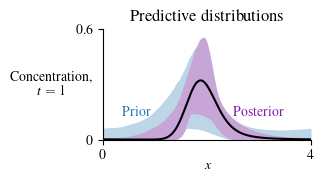

In [56]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m.x, pri_x_q5, pri_x_q95, color=prior_colors[0])
ax.fill_between(m.x, post_x_q5, post_x_q95, color=posterior_colors[0])
ax.plot(m.x, m.truth_model.f_field_from_eigenvalues(t=t_pred), 'k')

ax.set_xlabel(r'$x$')
ax.xaxis.set_label_coords(0.5,-.18)
ax.set_xticks([0,4])
ax.set_xlim([0,4])
ax.spines[['top','right']].set_visible(False)
ax.set_ylim([0,round(ax.get_ylim()[-1],1)])
ax.set_yticks([0,ax.get_ylim()[-1]])
ax.set_yticklabels([0,ax.get_ylim()[-1]])
ax.set_title('Predictive distributions')

ax.set_ylabel('Concentration,\n'+rf'$t={t_pred}$', rotation=0, ha='center', va='center');
ax.yaxis.set_label_coords(-.25,0.5)
ax.annotate('Prior', (0.9,.15), ha='right', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (2.5,0.15), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/x_predictives.pdf', bbox_inches='tight')

In [44]:
pri_pred_t_samples = m.get_time_pushforward_samples(prior_samples)
post_pred_t_samples = m.get_time_pushforward_samples(pps)
pri_t_q5, pri_t_q95 = np.quantile(pri_pred_t_samples, q=[.025,.975], axis=0)
post_t_q5, post_t_q95 = np.quantile(post_pred_t_samples, q=[.025,.975], axis=0)

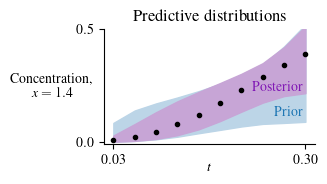

In [45]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m.calibration_tvec, pri_t_q5, pri_t_q95, color=prior_colors[0])
ax.fill_between(m.calibration_tvec, post_t_q5, post_t_q95, color=posterior_colors[0])
ax.plot(m.calibration_tvec, np.exp(m.calibration_data), 'k.')
ax.set_xlabel(r'$t$')
ax.xaxis.set_label_coords(0.5,-.15)
ax.set_ylabel('Concentration,\n'+rf'$x={m.x_calibration:.1f}$', va='center', ha='center', rotation=0);
ax.yaxis.set_label_coords(-.25,0.5)
ax.set_ylim([-.01, np.around(ax.get_ylim()[1],1)])
ax.set_yticks([0, ax.get_ylim()[1]])
ax.set_xticks([m.calibration_tvec[0], m.t_calibration])
ax.spines[['top','right']].set_visible(False)
ax.annotate('Prior', (0.295,0.13), ha='right', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.295, 0.24), ha='right', va='center', color=posterior_colors[1]);
ax.set_title('Predictive distributions')

fig.tight_layout()
fig.savefig(f'{m.figdir}/t_predictives.pdf', bbox_inches='tight')

### Show this behavior persists with more data

In [46]:
m2 = onlyFRADEMFU(FRADE_truth_model, t_calibration=0.9, Nt_calibration=60, results_dir='results/contaminant_transport/example_1/more_data/')

100%|██████████| 5000/5000 [01:20<00:00, 62.30it/s]


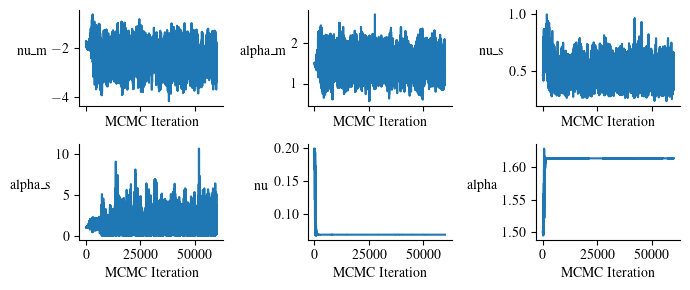

In [47]:
m2.run_mcmc(5000)
m2.plot_mcmc_chains()

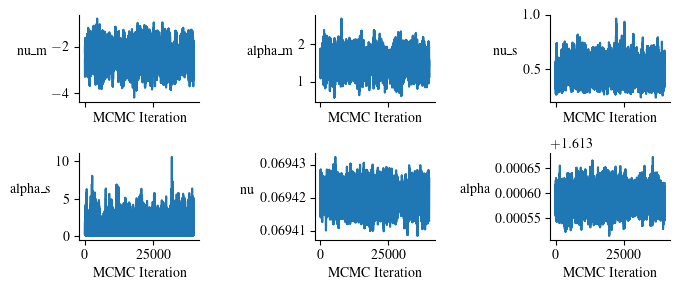

In [48]:
samples2 = m2.chains[20000:]
m2.plot_mcmc_chains(samples2)

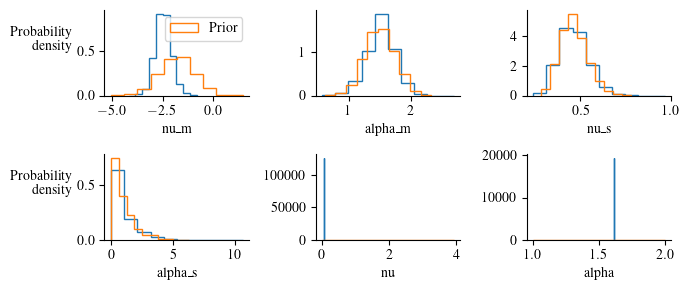

In [49]:
m2.plot_marginal_histograms(samples2, vs_prior=True)

Our parameter posteriors got more confident with more data, but our hyperparameter posteriors did not.

In [50]:
pri_pred_samples2 = m2.get_qoi_pushforward_samples(prior_samples)
# Hierarchically sample MFU parameters from hyperparameters
pps2 = m2.get_posterior_pushforward_samples(samples2[::10]) # downsampling
post_pred_samples2 = m2.get_qoi_pushforward_samples(pps2)

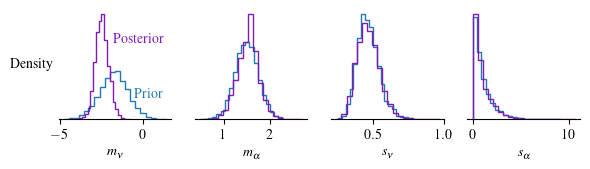

In [ ]:
fig = plt.figure(figsize=(6,1.8))
axs = fig.subplots(1,4)
bins=20
labels = [ r'$m_\nu$', r'$m_\alpha$', r'$s_\nu$', r'$s_\alpha$' ]
for ax, pris, posts, label in zip(axs, prior_samples.T, samples2[:,:-2].T, labels):
    ax.hist(pris, histtype='step', density=True, bins=bins, color=prior_colors[1]);
    ax.hist(posts, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
    ax.set_xlabel(label)

axs[0].set_ylabel('Density', rotation=0, ha='right', va='center')

for ax in axs:
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_yticks([])

axs[0].annotate('Prior', (-0.5,0.25), ha='left', va='center', color=prior_colors[1]);
axs[0].annotate('Posterior', (-1.8,0.8), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m2.figdir}/marginals.pdf', bbox_inches='tight')

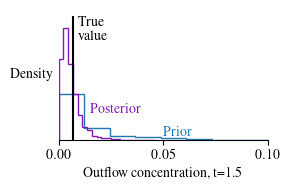

In [ ]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
bins=20
ax.hist(pri_pred_samples2, histtype='step', density=True, bins=bins, color=prior_colors[1]);
ax.hist(post_pred_samples2, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
qtrue = m2.truth_model.f_field_from_eigenvalues()[0]
ax.vlines(qtrue, 0, 1.05*ax.get_ylim()[1], color='k')
ax.annotate('True\nvalue', (qtrue*1.3, 0.95*ax.get_ylim()[1]), ha='left', va='top')


ax.set_ylabel('Density', rotation=0, ha='right', va='center')
ax.spines[['top','left','right']].set_visible(False)
ax.set_yticks([])

ax.set_xlim([0,0.1])
ax.set_xticks([0,0.05,0.1])

ax.set_xlabel(f'Outflow concentration, t={m2.truth_model.t}');
ax.annotate('Prior', (.05,8), ha='left', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.015,35), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m2.figdir}/qoi_predictives.pdf', bbox_inches='tight')

In [53]:
t_pred = 1
pri_pred_x_samples2 = m2.get_spatial_pushforward_samples(prior_samples, t=t_pred)
post_pred_x_samples2 = m2.get_spatial_pushforward_samples(pps2, t=t_pred)
pri_x_q5_2, pri_x_q95_2 = np.quantile(pri_pred_x_samples2, q=[.025,.975], axis=0)
post_x_q5_2, post_x_q95_2 = np.quantile(post_pred_x_samples2, q=[.025,.975], axis=0)

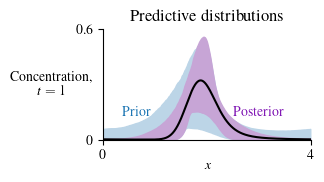

In [57]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m.x, pri_x_q5_2, pri_x_q95_2, color=prior_colors[0])
ax.fill_between(m.x, post_x_q5_2, post_x_q95_2, color=posterior_colors[0])
ax.plot(m2.x, m2.truth_model.f_field_from_eigenvalues(t=t_pred), 'k')

ax.set_xlabel(r'$x$')
ax.xaxis.set_label_coords(0.5,-.18)
ax.set_xticks([0,4])
ax.set_xlim([0,4])
ax.spines[['top','right']].set_visible(False)
ax.set_ylim([0,round(ax.get_ylim()[-1],1)])
ax.set_yticks([0,ax.get_ylim()[-1]])
ax.set_yticklabels([0,ax.get_ylim()[-1]])
ax.set_title('Predictive distributions')

ax.set_ylabel('Concentration,\n'+rf'$t={t_pred}$', rotation=0, ha='center', va='center');
ax.yaxis.set_label_coords(-.25,0.5)
ax.annotate('Prior', (0.9,.15), ha='right', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (2.5,0.15), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m2.figdir}/x_predictives.pdf', bbox_inches='tight')

In [61]:
pri_pred_t_samples2 = m2.get_time_pushforward_samples(prior_samples)
post_pred_t_samples2 = m2.get_time_pushforward_samples(pps2)
pri_t_q5_2, pri_t_q95_2 = np.quantile(pri_pred_t_samples2, q=[.025,.975], axis=0)
post_t_q5_2, post_t_q95_2 = np.quantile(post_pred_t_samples2, q=[.025,.975], axis=0)

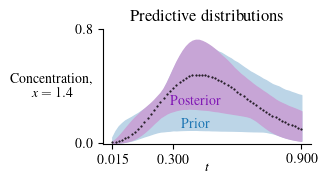

In [73]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m2.calibration_tvec, pri_t_q5_2, pri_t_q95_2, color=prior_colors[0])
ax.fill_between(m2.calibration_tvec, post_t_q5_2, post_t_q95_2, color=posterior_colors[0])
ax.plot(m2.calibration_tvec, np.exp(m2.calibration_data), 'k.', ms=1)
ax.set_xlabel(r'$t$')
ax.xaxis.set_label_coords(0.5,-.15)
ax.set_ylabel('Concentration,\n'+rf'$x={m.x_calibration:.1f}$', va='center', ha='center', rotation=0);
ax.yaxis.set_label_coords(-.25,0.5)
ax.set_ylim([-.01, np.around(ax.get_ylim()[1],1)])
ax.set_yticks([0, ax.get_ylim()[1]])
ax.set_xticks([m2.calibration_tvec[0], 0.3, m2.t_calibration])
ax.spines[['top','right']].set_visible(False)
ax.annotate('Prior', (0.4,0.13), ha='center', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.4, 0.29), ha='center', va='center', color=posterior_colors[1]);
ax.set_title('Predictive distributions')

fig.tight_layout()
fig.savefig(f'{m2.figdir}/t_predictives.pdf', bbox_inches='tight')

The posterior predictive distribution has barely changed despite having far more time-series data at twice the discretization level as before.

Now a figure comparing the posterior predictive on calibration data and QoI

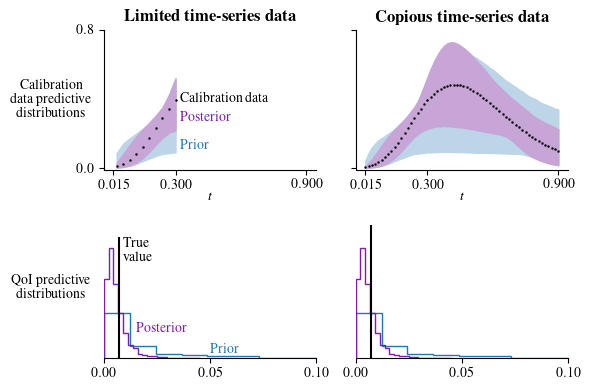

In [112]:
fig = plt.figure(figsize=(6,4))
axs = fig.subplots(2,2, sharey='row', sharex='row')

ax = axs[0,0]
ax.set_title(r'\textbf{Limited time-series data}')
ax.fill_between(m.calibration_tvec, pri_t_q5, pri_t_q95, color=prior_colors[0])
ax.fill_between(m.calibration_tvec, post_t_q5, post_t_q95, color=posterior_colors[0])
ax.plot(m.calibration_tvec, np.exp(m.calibration_data), 'k.', ms=1.5)
ax.set_xlabel(r'$t$')
ax.xaxis.set_label_coords(0.5,-.15)
#ax.set_ylabel('Concentration,\n'+rf'$x={m.x_calibration:.1f}$', va='center', ha='center', rotation=0);
ax.set_ylabel('Calibration\ndata predictive\ndistributions', va='center', ha='center', rotation=0);
ax.yaxis.set_label_coords(-.25,0.5)
#ax.set_ylim([-.01, np.around(ax.get_ylim()[1],1)])
ax.set_yticks([0, ax.get_ylim()[1]])
ax.set_xticks([m.calibration_tvec[0], m.t_calibration])
ax.spines[['top','right']].set_visible(False)
ax.annotate('Prior', (0.32,0.13), ha='left', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.32, 0.29), ha='left', va='center', color=posterior_colors[1]);
ax.annotate('Calibration data', (0.32, 0.4), ha='left', va='center');

ax = axs[0,1]
ax.set_title(r'\textbf{Copious time-series data}')
ax.fill_between(m2.calibration_tvec, pri_t_q5_2, pri_t_q95_2, color=prior_colors[0])
ax.fill_between(m2.calibration_tvec, post_t_q5_2, post_t_q95_2, color=posterior_colors[0])
ax.plot(m2.calibration_tvec, np.exp(m2.calibration_data), 'k.', ms=1.5)
ax.set_xlabel(r'$t$')
ax.xaxis.set_label_coords(0.5,-.15)
ax.yaxis.set_label_coords(-.25,0.5)
ax.set_ylim([-.01, np.around(ax.get_ylim()[1],1)])
ax.set_yticks([0, ax.get_ylim()[1]])
ax.set_xticks([m2.calibration_tvec[0], 0.3, m2.t_calibration])
ax.spines[['top','right']].set_visible(False)

ax = axs[1,0]
bins=20
ax.hist(pri_pred_samples2, histtype='step', density=True, bins=bins, color=prior_colors[1]);
ax.hist(post_pred_samples2, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
qtrue = m2.truth_model.f_field_from_eigenvalues()[0]
ax.vlines(qtrue, 0, 1.05*ax.get_ylim()[1], color='k')
ax.annotate('True\nvalue', (qtrue*1.3, 0.95*ax.get_ylim()[1]), ha='left', va='top')


ax.set_ylabel('QoI predictive\ndistributions', rotation=0, ha='center', va='center')
ax.spines[['top','left','right']].set_visible(False)
ax.set_yticks([])

ax.set_xlim([0,0.1])
ax.set_xticks([0,0.05,0.1])

ax.yaxis.set_label_coords(-.25,0.5)
ax.annotate('Prior', (.05,10), ha='left', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.015,35), ha='left', va='center', color=posterior_colors[1]);

ax = axs[1,1]
ax.hist(pri_pred_samples2, histtype='step', density=True, bins=bins, color=prior_colors[1]);
ax.hist(post_pred_samples2, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
qtrue = m2.truth_model.f_field_from_eigenvalues()[0]
ax.vlines(qtrue, 0, 1.05*ax.get_ylim()[1], color='k')

ax.spines[['top','left','right']].set_visible(False)
ax.set_yticks([])

ax.set_xlim([0,0.1])
ax.set_xticks([0,0.05,0.1])

fig.tight_layout()
fig.savefig(f'{m2.figdir}/predictives_compare.pdf', bbox_inches='tight')

# Now we can't reproduce the data

In [16]:
m = onlyFRADEMFU(generalizedADE_truth_model, t_calibration=t_calibration, results_dir='results/contaminant_transport/example_2/')

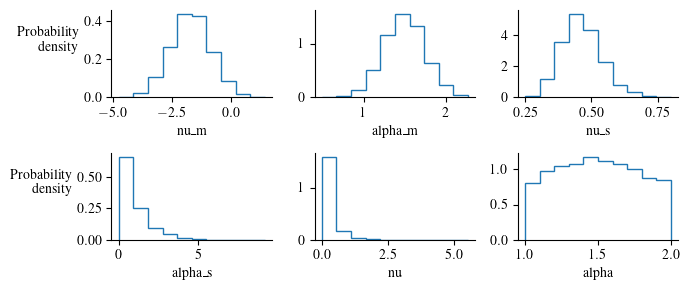

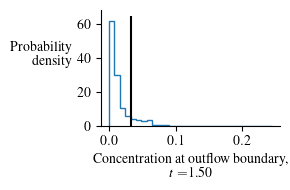

In [17]:
np.random.seed(20250810)
prior_samples = m.get_prior_samples(5000)
m.plot_marginal_histograms(prior_samples)
m.plot_qoi_pushforward(prior_samples,with_noise=True)

  0%|          | 24/5000 [00:00<01:08, 72.74it/s]/Users/tporton/git_repos/mfu_gsa/hierarchical-bayes-issues-results/dispersion_MFU_representations.py:629: RuntimeWarning: invalid value encountered in log
  f = np.log(self.f_time_field(theta, self.calibration_tvec, self.x_calibration).flatten(order='F'))
100%|██████████| 5000/5000 [01:05<00:00, 76.87it/s]


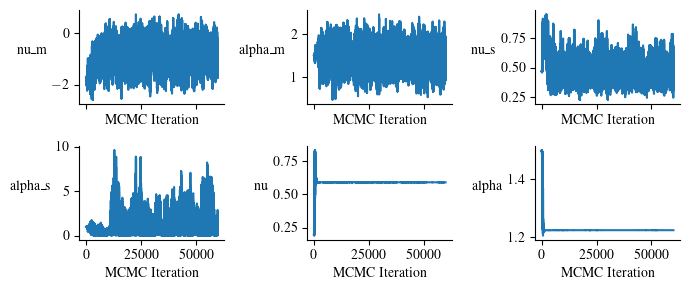

In [18]:
m.run_mcmc(5000)
m.plot_mcmc_chains()

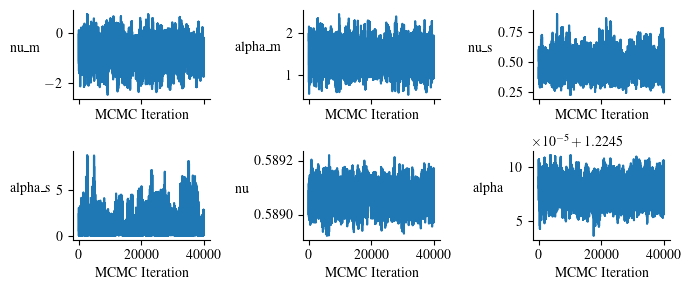

In [19]:
samples = m.chains[20000:]
m.plot_mcmc_chains(samples)

In [20]:
pri_pred_samples = m.get_qoi_pushforward_samples(prior_samples)
# Hierarchically sample MFU parameters from hyperparameters
pps = m.get_posterior_pushforward_samples(samples[::10]) # downsampling
post_pred_samples = m.get_qoi_pushforward_samples(pps)

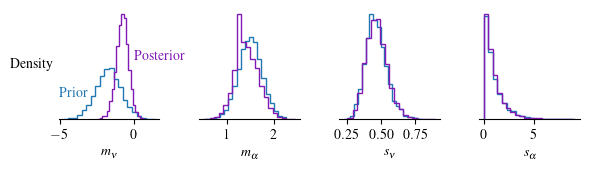

In [21]:
fig = plt.figure(figsize=(6,1.8))
axs = fig.subplots(1,4)
bins=20
labels = [ r'$m_\nu$', r'$m_\alpha$', r'$s_\nu$', r'$s_\alpha$' ]
for ax, pris, posts, label in zip(axs, prior_samples.T, samples[:,:-2].T, labels):
    ax.hist(pris, histtype='step', density=True, bins=bins, color=prior_colors[1]);
    ax.hist(posts, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
    ax.set_xlabel(label)

axs[0].set_ylabel('Density', rotation=0, ha='right', va='center')

for ax in axs:
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_yticks([])

axs[0].annotate('Prior', (-3.2,0.25), ha='right', va='center', color=prior_colors[1]);
axs[0].annotate('Posterior', (0,0.6), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/marginals.pdf', bbox_inches='tight')

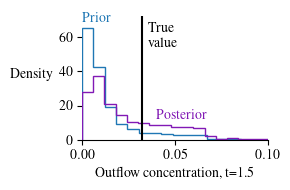

In [22]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
bins=40
ax.hist(pri_pred_samples, histtype='step', density=True, bins=bins, color=prior_colors[1]);
ax.hist(post_pred_samples, histtype='step', density=True, bins=bins, color=posterior_colors[1]);
qtrue = m.truth_model.f_field_from_eigenvalues()[0]
ax.vlines(qtrue, 0, 1.05*ax.get_ylim()[1], color='k')
ax.annotate('True\nvalue', (qtrue*1.1, 0.9*ax.get_ylim()[1]), ha='left', va='top')

ax.set_ylabel('Density', rotation=0, ha='right', va='center')
ax.spines[['top','left','right']].set_visible(False)
# ax.set_yticks([])

ax.set_xlim([0,0.1])
ax.set_xticks([0,0.05,0.1])

ax.set_xlabel(f'Outflow concentration, t={m.truth_model.t}');
ax.annotate('Prior', (0,67), ha='left', va='bottom', color=prior_colors[1]);
ax.annotate('Posterior', (0.04, 14), ha='left', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/qoi_predictives.pdf', bbox_inches='tight')

In [23]:
t_pred = 1
pri_pred_x_samples = m.get_spatial_pushforward_samples(prior_samples, t=t_pred)
post_pred_x_samples = m.get_spatial_pushforward_samples(pps, t_pred)
pri_x_q5, pri_x_q95 = np.quantile(pri_pred_x_samples, q=[.025,.975], axis=0)
post_x_q5, post_x_q95 = np.quantile(post_pred_x_samples, q=[.025,.975], axis=0)

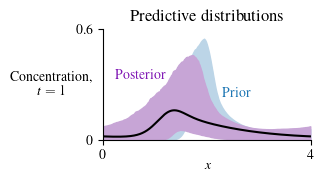

In [24]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m.x, pri_x_q5, pri_x_q95, color=prior_colors[0])
ax.fill_between(m.x, post_x_q5, post_x_q95, color=posterior_colors[0])
ax.plot(m.x, m.truth_model.f_field_from_eigenvalues(t=t_pred), 'k')

ax.set_xlabel(r'$x$')
ax.xaxis.set_label_coords(0.5,-.18)
ax.set_xticks([0,4])
ax.set_xlim([0,4])
ax.spines[['top','right']].set_visible(False)
ax.set_ylim([0,round(ax.get_ylim()[-1],1)])
ax.set_yticks([0,ax.get_ylim()[-1]])
ax.set_yticklabels([0,ax.get_ylim()[-1]])
ax.set_title('Predictive distributions')

ax.set_ylabel('Concentration,\n'+rf'$t={t_pred}$', rotation=0, ha='center', va='center');
ax.yaxis.set_label_coords(-.25,0.5)
ax.annotate('Prior', (2.3,0.25), ha='left', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (1.2,0.35), ha='right', va='center', color=posterior_colors[1]);

fig.tight_layout()
fig.savefig(f'{m.figdir}/x_predictives.pdf', bbox_inches='tight')

In [25]:
pri_pred_t_samples = m.get_time_pushforward_samples(prior_samples)
post_pred_t_samples = m.get_time_pushforward_samples(pps)
pri_t_q5, pri_t_q95 = np.quantile(pri_pred_t_samples, q=[.025,.975], axis=0)
post_t_q5, post_t_q95 = np.quantile(post_pred_t_samples, q=[.025,.975], axis=0)

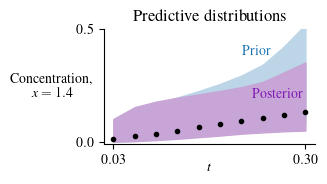

In [31]:
fig = plt.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
ax.fill_between(m.calibration_tvec, pri_t_q5, pri_t_q95, color=prior_colors[0])
ax.fill_between(m.calibration_tvec, post_t_q5, post_t_q95, color=posterior_colors[0])
ax.plot(m.calibration_tvec, np.exp(m.calibration_data), 'k.')
ax.set_xlabel(r'$t$')
ax.xaxis.set_label_coords(0.5,-.15)
ax.set_ylabel('Concentration,\n'+rf'$x={m.x_calibration:.1f}$', va='center', ha='center', rotation=0);
ax.yaxis.set_label_coords(-.25,0.5)
ax.set_ylim([-.01, np.around(ax.get_ylim()[1],1)])
ax.set_yticks([0, ax.get_ylim()[1]])
ax.set_xticks([m.calibration_tvec[0], m.t_calibration])
ax.spines[['top','right']].set_visible(False)
ax.annotate('Prior', (0.25, 0.4), ha='right', va='center', color=prior_colors[1]);
ax.annotate('Posterior', (0.295, 0.21), ha='right', va='center', color=posterior_colors[1]);
ax.set_title('Predictive distributions')

fig.tight_layout()
fig.savefig(f'{m.figdir}/t_predictives.pdf', bbox_inches='tight')